0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Get data

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Unzipping pizza, steak, sushi data...


2. Data Preparation


In [5]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [24]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

2.1 Visualize an image

1. get all the image paths which are files ending with .jpg
2. pick a random image
3. get the image class name which is the parent of the files
4. since we are working with images, we'll open random image path using PIL.Image.open()
5. We will se the metadata

 Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
 Image class: sushi, Image height: 408, Image width: 512


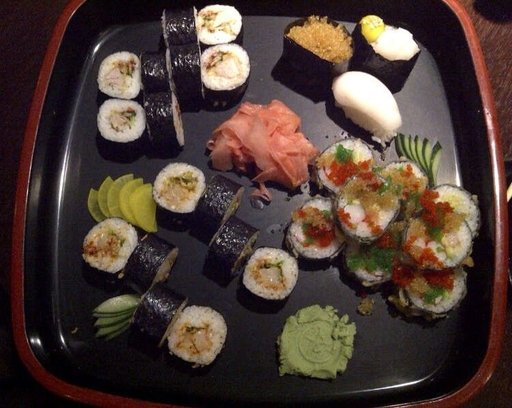

In [25]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f" Random image path: {random_image_path}")
print(f" Image class: {image_class}, Image height: {img.height}, Image width: {img.width}")

img

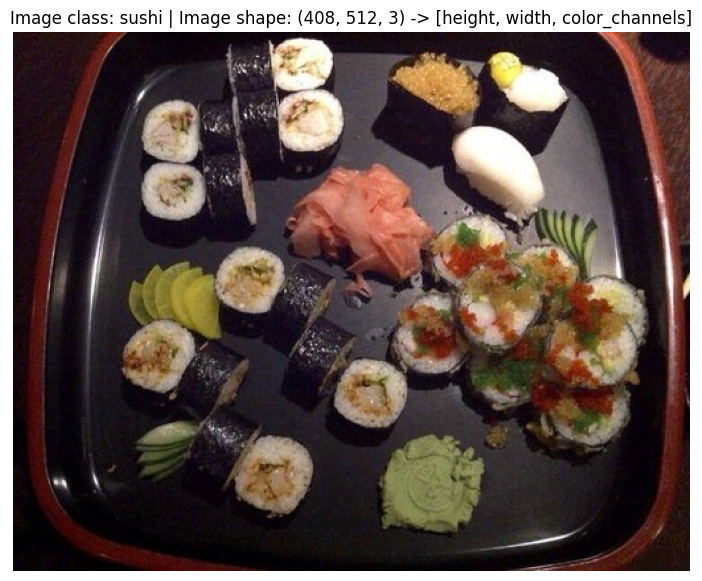

In [16]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

3. Transforming data

In [26]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

3.1 Transforming data torchvision.transforms

In [27]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

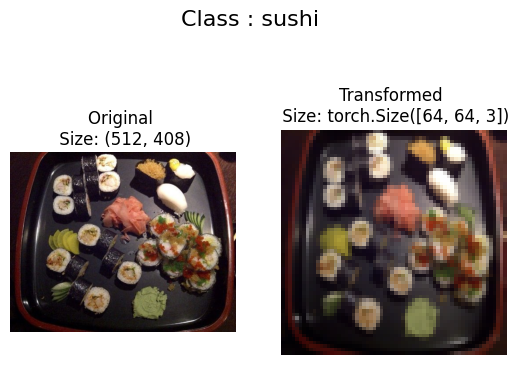

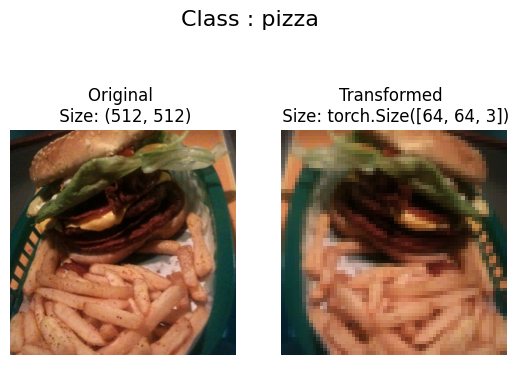

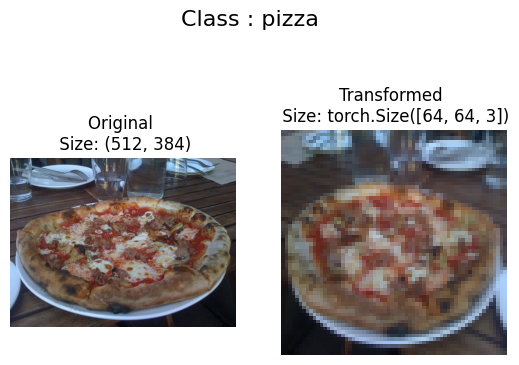

In [28]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size: {f.size}")
            ax[0].axis(False)
            
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_path_list,
                        transform= data_transforms,
                        n=3
                        )

4. Option 1 : loading image data using ImageFolder

In [29]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transforms)

print(f"Train data: \n {train_data}\nTest data:\n{test_data}")

Train data: 
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [31]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [32]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
img, label =  train_data[0][0], train_data[0][1]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


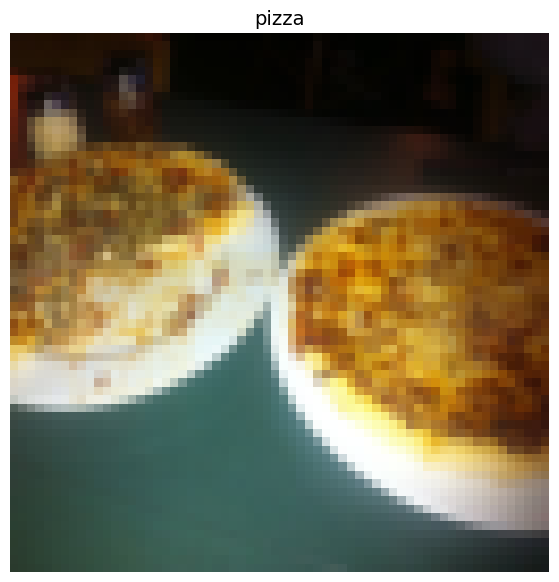

In [34]:
#rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

4.1 Turn loaded images into DataLoader's

In [35]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x20d063637c0>,
 <torch.utils.data.dataloader.DataLoader at 0x20d06360be0>)

In [36]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


5. Option 2: Loading Image Data with a Custom Dataset

In [37]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [38]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

5.1 Creating a a helper function to get classes names

In [39]:
target_directory = train_dir
print(f"Target Directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"class names found: {class_names_found}")

Target Directory: data\pizza_steak_sushi\train
class names found: ['pizza', 'steak', 'sushi']


In [40]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    
    classes =  sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
    
    if not classes:
        raise FileNotFoundError("fCouldnt find any classes in {directory}.")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


In [41]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

5.2 Create a custom Dataset to replicate ImageFolder

In [66]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        
        self.transform = transform
        
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> Image.Image:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
        

In [67]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [68]:
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir= test_dir,
                                      transform=train_transforms)

train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x20d05dc6dd0>,
 <__main__.ImageFolderCustom at 0x20d05d92080>)

In [69]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [70]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [71]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

5.3 Create a function to display random images

In [72]:

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

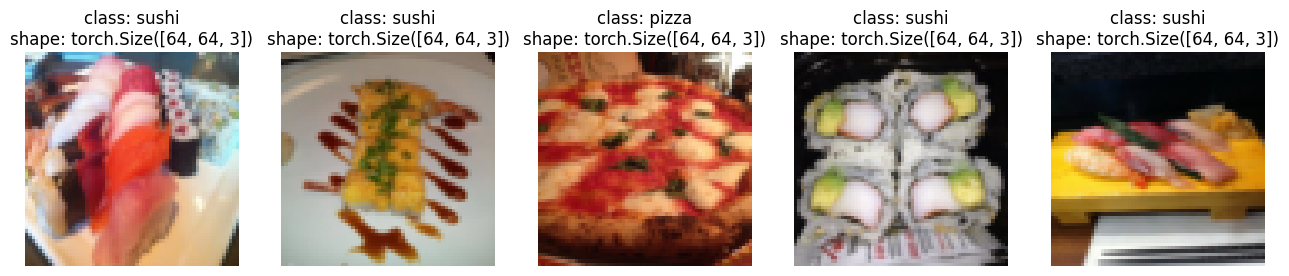

In [74]:
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

5.4 Turn Custom loaded images into DataLoader's

In [77]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size =1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size =1,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x20d0800ad70>,
 <torch.utils.data.dataloader.DataLoader at 0x20d0800ae00>)

In [78]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


6. Other forms of transforms (data augmentation)

In [79]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

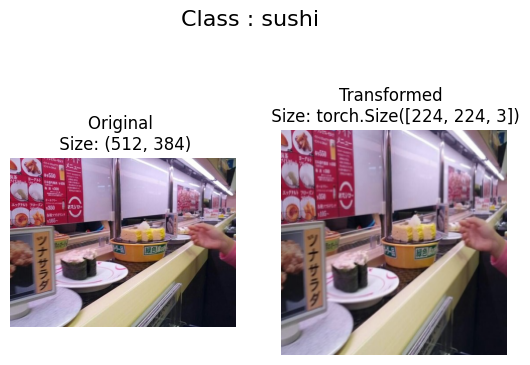

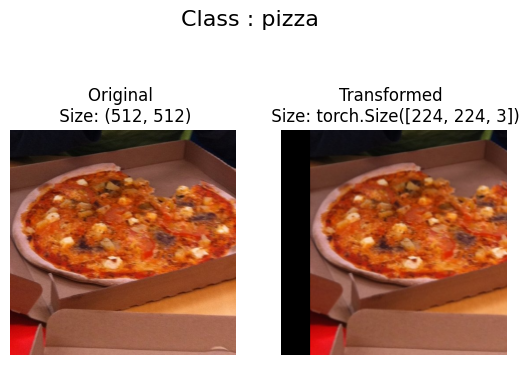

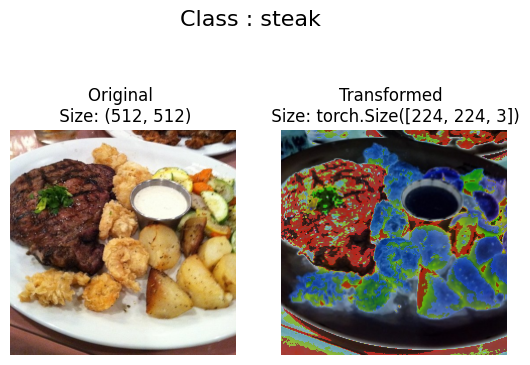

In [80]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths= image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

### 7. Model 0 : TingVGG without data augmentation

7.1 Creating transforms and loading data for model 0

In [84]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [87]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"creating Dataloader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = DataLoader(train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_simple = DataLoader(test_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

train_dataloader_simple, test_dataloader_simple 

creating Dataloader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x20d086906d0>,
 <torch.utils.data.dataloader.DataLoader at 0x20d08693eb0>)

7.2 Create TinyVGG model class

In [91]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      padding=0,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=0,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=0,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=0,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device=device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

7.3 Try a forward pass on a single image( to test the model)


In [92]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0216, -0.0367,  0.0237]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3395, 0.3203, 0.3402]], device='cuda:0')

Output prediction label:
tensor([2], device='cuda:0')

Actual label:
0


7.4 Use torchinfo to get idea of the shapes going through our model

In [94]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─MaxPool2d: 2-4                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-5                       [1, 10, 28, 28]           910
│    └─ReLU: 2-6                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-7                       [1, 10, 26, 26]           910
│    └─MaxPool2d: 2-8                    [1, 10, 13, 13]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 1690]                 --
│    └─Line

7.5 Create train and test loop functions

In [95]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        #forward pass
        y_pred = model(X)
        
        #cal the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        #optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()
        
        #optimizewr step
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc
        

In [110]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module
               ):
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            
            #forward pass
            test_pred_logits = model(X)
            
            #cal the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
        
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

7.6 Creating a train() function to to combine train_step() and test_step()


In [111]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
    epochs: int = 5
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results
        

7.7 Train and Evaluate Model 0

In [112]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"total training time: {end_time - start_time:.3f} seconds")



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:20<01:22, 20.54s/it]

Epoch: 1 | train_loss: 1.1160 | train_acc: 0.2617 | test_loss: 1.1044 | test_acc: 0.1979


 40%|████      | 2/5 [00:42<01:03, 21.28s/it]

Epoch: 2 | train_loss: 1.1048 | train_acc: 0.3242 | test_loss: 1.0552 | test_acc: 0.5417


 60%|██████    | 3/5 [01:02<00:41, 20.92s/it]

Epoch: 3 | train_loss: 1.0825 | train_acc: 0.4648 | test_loss: 1.0650 | test_acc: 0.5634


 80%|████████  | 4/5 [01:24<00:21, 21.05s/it]

Epoch: 4 | train_loss: 1.0978 | train_acc: 0.4180 | test_loss: 1.0183 | test_acc: 0.4223


100%|██████████| 5/5 [01:45<00:00, 21.14s/it]

Epoch: 5 | train_loss: 1.0126 | train_acc: 0.4258 | test_loss: 1.0509 | test_acc: 0.4129
total training time: 105.721 seconds


In [113]:
device

'cuda'

7.8 Plot the loss curves of Model 0

In [114]:
def plot_loss_curves(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

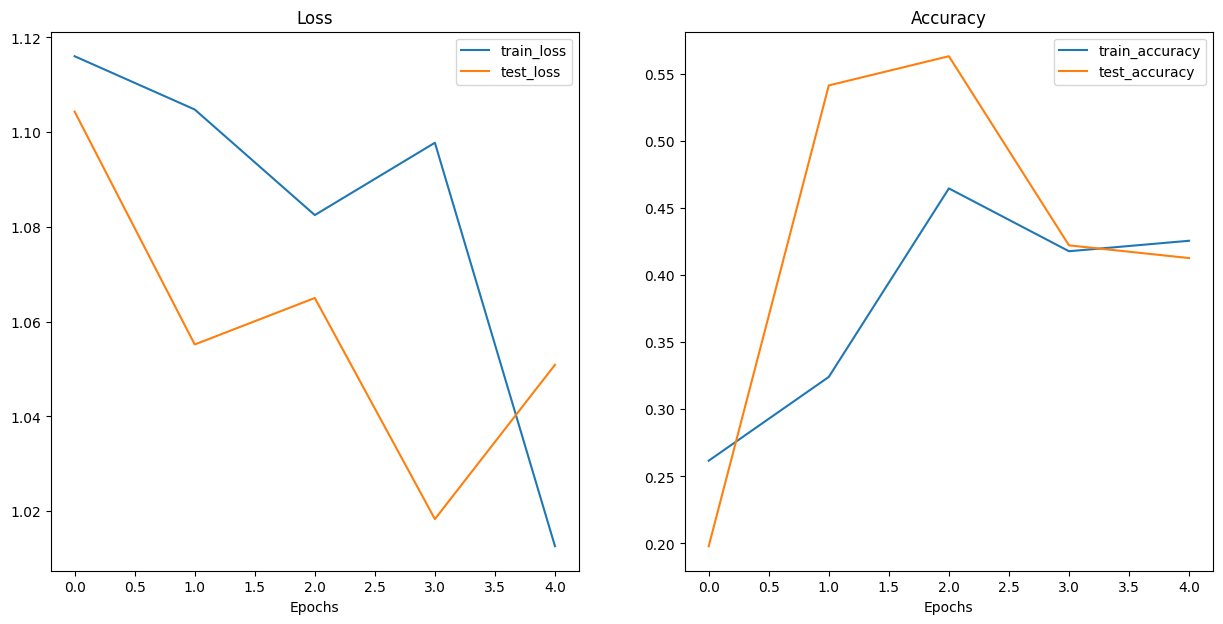

In [115]:
plot_loss_curves(model_0_results)

### 9 Model 1 tinyvgg with data augmentation

9.1 create transform with data augmentation

In [116]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

9.2 Create train and test datasets and dataloader

In [117]:
train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

train_data_augment, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [122]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augment,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x20d7cfcbbe0>,
 <torch.utils.data.dataloader.DataLoader at 0x20d06360df0>)

9.3 Construct and train MOdel1

In [124]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augment.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [125]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total time for training: {end_time - start_time:.3f} seconds")

 20%|██        | 1/5 [00:34<02:18, 34.63s/it]

Epoch: 1 | train_loss: 1.1082 | train_acc: 0.2969 | test_loss: 1.1294 | test_acc: 0.2604


 40%|████      | 2/5 [01:07<01:40, 33.40s/it]

Epoch: 2 | train_loss: 1.0719 | train_acc: 0.4258 | test_loss: 1.1702 | test_acc: 0.2604


 60%|██████    | 3/5 [01:43<01:09, 34.66s/it]

Epoch: 3 | train_loss: 1.0793 | train_acc: 0.4258 | test_loss: 1.1744 | test_acc: 0.2604


 80%|████████  | 4/5 [02:18<00:34, 34.77s/it]

Epoch: 4 | train_loss: 1.1018 | train_acc: 0.3125 | test_loss: 1.1280 | test_acc: 0.3229


100%|██████████| 5/5 [02:51<00:00, 34.25s/it]

Epoch: 5 | train_loss: 1.0449 | train_acc: 0.5234 | test_loss: 1.1033 | test_acc: 0.3116
Total time for training: 171.258 seconds


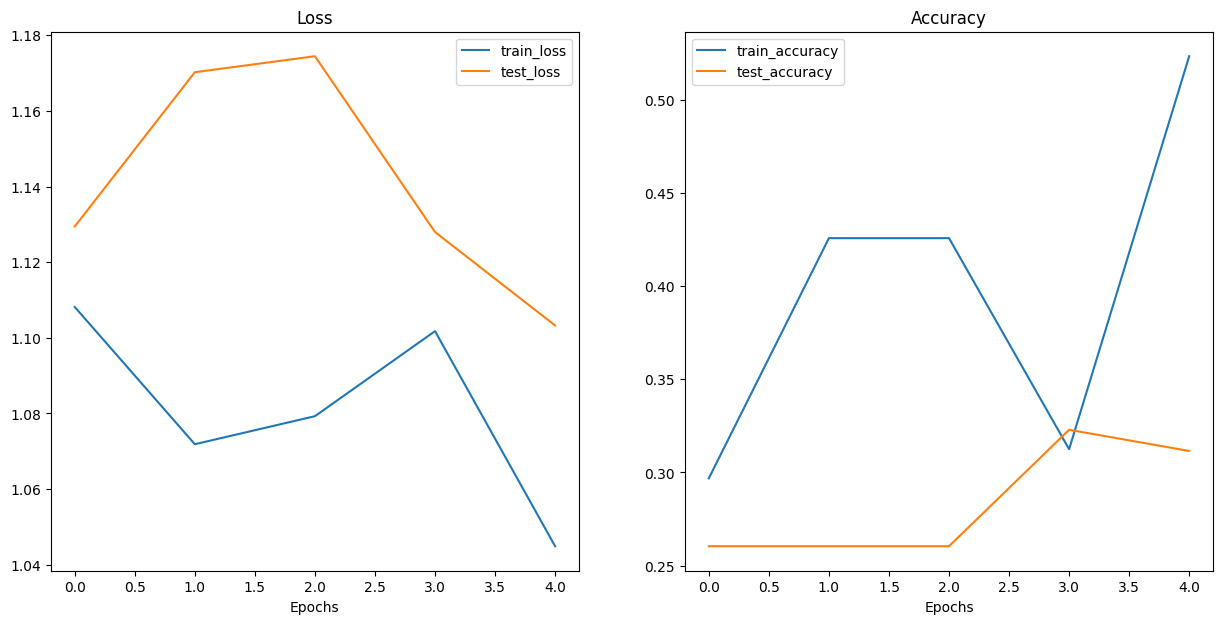

In [126]:
plot_loss_curves(model_1_results)
